<h2>Prototype</h2>

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
from scipy.signal import get_window
from scipy.io import wavfile
import IPython

In [100]:
fs, x = wavfile.read("c-major-scale.wav")
x = x / np.max(abs(x))

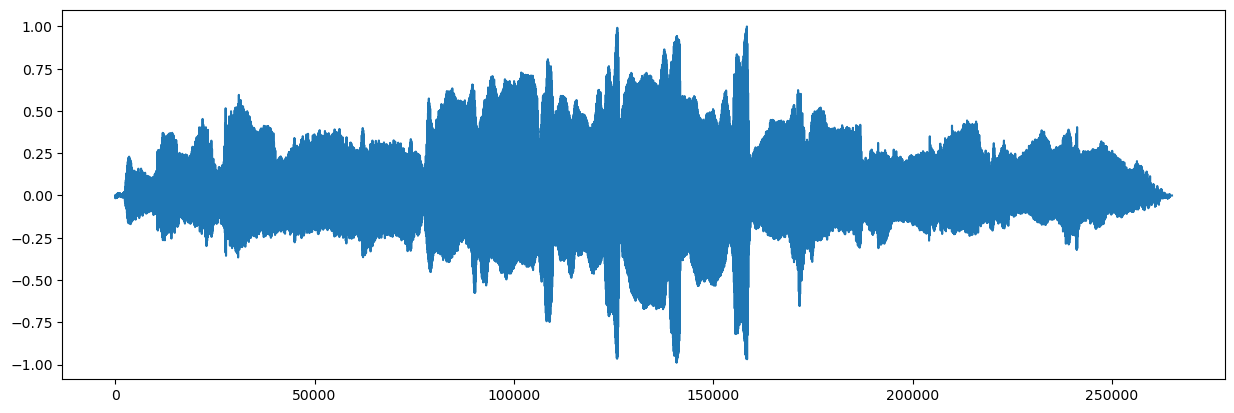

In [101]:
plt.figure().set_figwidth(15)
plt.plot(x)
IPython.display.Audio(x, rate=fs)

In [102]:
M=8001
N=8192
H=256

hM1 = int(math.floor((M + 1) / 2))
hM2 = int(math.floor(M / 2))
eps = np.finfo(float).eps

In [103]:
w  = get_window('hann', M)
w = w / sum(w)

In [104]:
def computeSpectrum(x):
    spectrum = []

    l = 0
    while l < len(x) - M:
        y = x[l: l + M] * w

        fftBuffer = np.zeros(N)
        fftBuffer[: hM1] = y[hM2:] 
        fftBuffer[N - hM2:] = y[: hM2]

        X = fft(fftBuffer)
        absX = abs(X)
        absX[absX < np.finfo(float).eps] = np.finfo(float).eps
        mX = 20 * np.log10(absX)
        spectrum.append(mX)

        l += H
    
    return spectrum

In [105]:
spectrum = computeSpectrum(x)

In [106]:
t = np.arange(len(spectrum)) * H / fs
fqs = np.arange(N) * fs / N

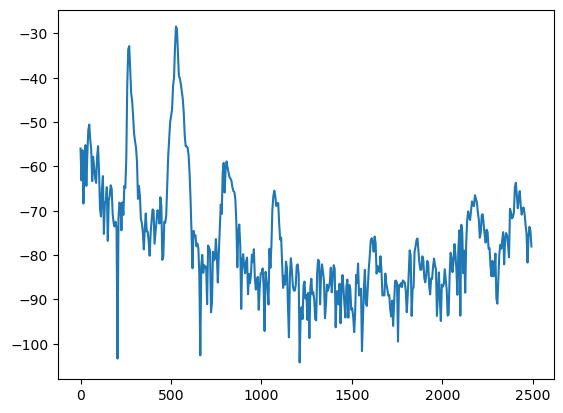

In [122]:
plt.plot(fqs[:f], spectrum[0][:f])

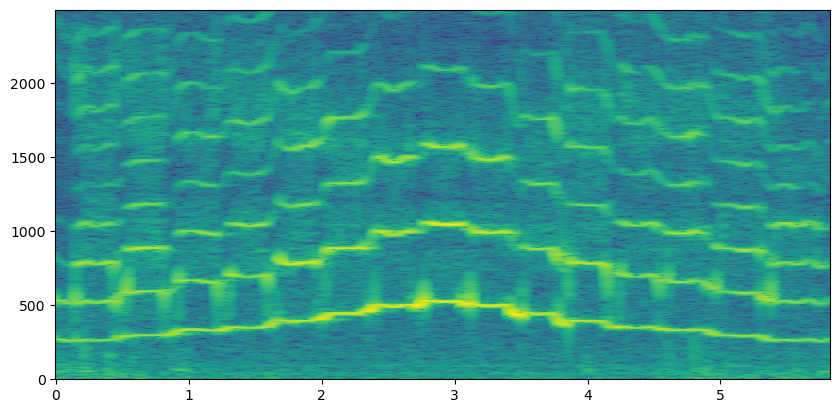

In [108]:
f = int(2500 * N / fs)
spectrum = np.array(spectrum)
plt.figure().set_figwidth(10)
fqs = np.arange(N) * fs / N
plt.pcolormesh(t, fqs[:f], spectrum.T[:f])

In [117]:
peaks_k = []
peaks_mX = []

for i in range(len(spectrum)):
    ks = []
    mXs = []
    for j in range(1, int(f)):
        #print(spectrum[i][j])
        if spectrum[i][j] < -40: continue
            
        elif spectrum[i][j-1] < spectrum[i][j] and spectrum[i][j] > spectrum[i][j+1]:
            ks.append(j * fs / N)
            mXs.append(spectrum[i][j])
    
    peaks_k.append(ks)
    peaks_mX.append(mXs)

In [123]:
peaks_k[0]

[269.1650390625, 527.5634765625]

In [119]:
peaks_mX[300]

[-25.262302784897845,
 -20.664545960034797,
 -33.222427874713766,
 -37.29411786607979,
 -39.108018123798686]

In [126]:
fundamentals = []
for i in range(len(peaks_k)):
    candidates = []
    
    num = len(peaks_k[i])
    if num == 1:
        f0 = peaks_k[i][0]
        fundamentals.append(f0)
        continue
        
    elif num == 2:
        f0 = peaks_k[i][1] - peaks_k[i][0]
        fundamentals.append(f0)
        continue
    
    for j in range(num-1):
        #print(peaks_k[i][j+1] - peaks_k[i][j])
        candidates.append(peaks_k[i][j+1] - peaks_k[i][j])
        
    f0 = candidates[0]
    least_err = 99999
        
    for fr in candidates:
        errpm = 0
        errmp = 0
        
        for j in range(num):
            errpm += (fr * (j+1) - peaks_k[i][j]) * (fr * (j+1))**(-0.5) + peaks_mX[i][j] / max(peaks_mX[i]) * (1.4 * (fr * (j+1) - peaks_k[i][j]) * (fr * (j+1))**(-0.5) - 0.5)
            errmp += (fr * (j+1) - peaks_k[i][j]) * (peaks_k[i][j])**(-0.5) + peaks_mX[i][j] / max(peaks_mX[i]) * (1.4 * (fr * (j+1) - peaks_k[i][j]) * (peaks_k[i][j])**(-0.5) - 0.5)
        
        err_tot = (errpm + errmp) / num
        if err_tot < least_err:
            least_err = err_tot
            f0 = fr
    
    fundamentals.append(f0)

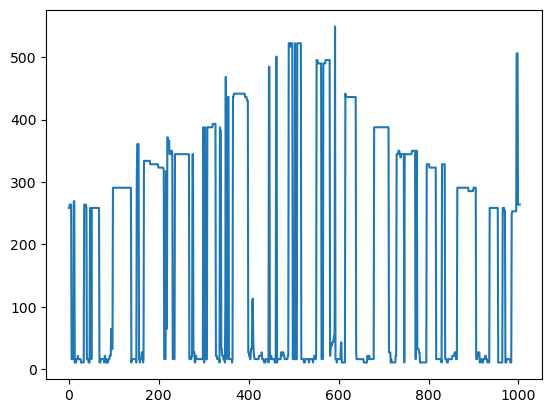

In [127]:
plt.plot(fundamentals)

<h4>Needs a nueral network to identify the peaks</h4>